p torch.Size([1600, 3])
r torch.Size([1600, 3])


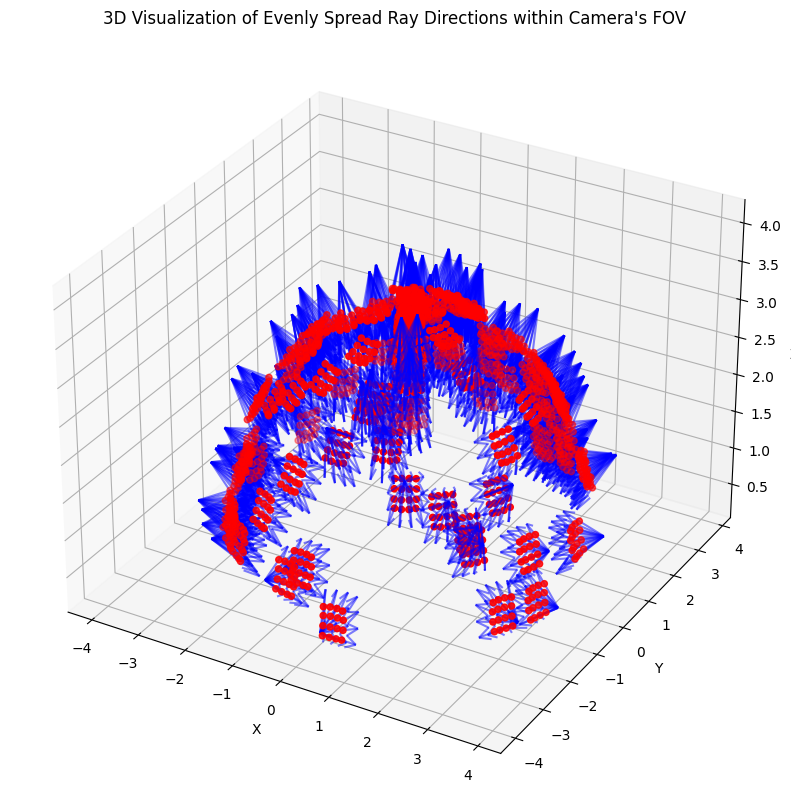

In [468]:
import json
from mpl_toolkits.mplot3d import Axes3D

def get_data_from_index(data, index):
    camera_angle_x = data["camera_angle_x"]
    frame = data["frames"][index]

    file_path = frame["file_path"]
    rotation = frame["rotation"]
    transform_matrix = torch.tensor(frame["transform_matrix"])

    return transform_matrix, rotation, file_path, camera_angle_x


def generate_rays(num_rays, transform_matrix, camera_angle_x, even_spread=False):

    # Extract camera axes and position
    camera_x_axis = transform_matrix[:3, 0]
    camera_y_axis = transform_matrix[:3, 1]
    camera_z_axis = -transform_matrix[:3, 2]

    # Compute the aspect ratio (width / height) of the camera's FOV
    aspect_ratio = camera_x_axis.norm() / camera_y_axis.norm()

    # Generate evenly spread ray indices
    if even_spread:
        num_rays_sqrt = np.round(np.sqrt(num_rays))
        
        u_values = torch.linspace(-0.5 * camera_angle_x, 0.5 * camera_angle_x, int(num_rays_sqrt))
        v_values = torch.linspace(-0.5 * camera_angle_x / aspect_ratio, 0.5 * camera_angle_x / aspect_ratio, int(num_rays_sqrt))
        ray_indices = torch.cartesian_prod(u_values, v_values)
        
    else:
        # Generate random ray indices
        ray_indices = torch.rand(num_rays, 2)  # Generate random numbers in the range [0, 1)

        # Scale and shift the ray indices to match the camera's FOV
        ray_indices[:, 0] = camera_angle_x * (ray_indices[:, 0] - 0.5)
        ray_indices[:, 1] = camera_angle_x / aspect_ratio * (ray_indices[:, 1] - 0.5)

    # Get the u and v values from ray_indices
    u_values, v_values = ray_indices[:, 0].unsqueeze(-1), ray_indices[:, 1].unsqueeze(-1)
    directions = u_values * camera_x_axis + v_values * camera_y_axis + camera_z_axis
    
    ray_directions = directions / directions.norm(dim=1).unsqueeze(-1)

    return ray_directions

def get_camera_normal(transform_matrix):
    fixed_pos = transform_matrix[:3, :3].unsqueeze(0)
    fixed_pos[:,2] = fixed_pos[:,2]* -1
    return fixed_pos

def visulize_rays(ray_directions, camera_positions):

    # Orthographic projection: discard the z-coordinate
    ray_directions_2d = ray_directions[:, :2]

    # Plot the 2D vectors
    plt.figure(figsize=(10, 10))
    origin_x = camera_positions[:, 0]
    origin_y = camera_positions[:, 1]

    plt.quiver(origin_x, origin_y,
                ray_directions_2d[:, 0], ray_directions_2d[:, 1], angles='xy', scale_units='xy',
               scale=1)
    # plt.xlim(-2, 2)
    # plt.ylim(-2, 2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.title("Orthographic Projection of Evenly Spread Ray Directions within Camera's FOV")
    plt.grid()
    plt.show()

def visualize_rays_3d(ray_directions, camera_positions, scatter_data=None):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    origin_x = camera_positions[:, 0]
    origin_y = camera_positions[:, 1]
    origin_z = camera_positions[:, 2]

    # Plot 3D vectors
    for i in range(ray_directions.shape[0]):
        ax.quiver(origin_x[i], origin_y[i], origin_z[i],
                  ray_directions[i, 0], ray_directions[i, 1], ray_directions[i, 2],
                  color='b', alpha=0.5)

    if not scatter_data is None:
        scatter_x = scatter_data[:, 0]
        scatter_y = scatter_data[:, 1]
        scatter_z = scatter_data[:, 2]
        ax.scatter(scatter_x, scatter_y, scatter_z, c='r', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("3D Visualization of Evenly Spread Ray Directions within Camera's FOV")
    plt.show()

data_folder = "D:\9.programming\Plenoxels\data"
object_folders = ['chair', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic', 'ship']

with open(f"{data_folder}/{object_folders[0]}/transforms_train.json", "r") as f:
    data = json.load(f)

number_of_rays = 16
ray_directions = torch.zeros([])
camera_positions = torch.zeros([])
for i in range(len(data["frames"])):
    transform_matrix, rotation, file_path, camera_angle_x = get_data_from_index(data, i)

    # current_ray_directions = transform_matrix[:3, 2].unsqueeze(0)* -1
    # camera_positions = transform_matrix[:3, 3].unsqueeze(0) if len(camera_positions.shape) == 0 else torch.cat([camera_positions, transform_matrix[:3, 3].unsqueeze(0)], 0)

    current_ray_directions = generate_rays(number_of_rays, transform_matrix, camera_angle_x, even_spread=True)
    ray_directions = current_ray_directions if len(ray_directions.shape) == 0 else torch.cat([ray_directions, current_ray_directions], 0)
    camera_positions = transform_matrix[:3, 3].unsqueeze(0).repeat(number_of_rays,1) if len(camera_positions.shape) == 0 else torch.cat([camera_positions, transform_matrix[:3, 3].unsqueeze(0).repeat(number_of_rays,1)], 0)

samples = camera_positions + ray_directions*delta_step

print("p",camera_positions.shape)
print("r",ray_directions.shape)

visualize_rays_3d(ray_directions, camera_positions, samples)


In [470]:
# ray_directions 
# camera_positions
num_samples = 40
delta_step = 0.6
samples = camera_positions + ray_directions*delta_step
samples.shape# torch.arange(num_samples)*delta_step

torch.Size([1600, 3])

In [471]:
(camera_positions + ray_directions)

torch.Size([1600, 3])